<a href="https://colab.research.google.com/github/linsalrob/CF_Data_Analysis/blob/main/Jupyter/age_and_pathogenicity_minion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age and Pathogenicity

It seems that older people have more pathogens.

Do they? Can we separate that from hospital effects?

## Repeat the initial observation

I showed this in the mgi_metadata_pcas.ipynb notebook, but we also showed it elsewhere

In [1]:
import os
import sys

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import json

from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.stats import linregress


# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

try:
  import google.colab
  IN_COLAB = True
  !pip install adjustText
except ImportError:
  IN_COLAB = False

from adjustText import adjust_text

In [2]:
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  datadir = '/content/drive/MyDrive/Projects/CF/Adelaide/CF_Data_Analysis'
else:
  datadir = '..'

Mounted at /content/drive


## Set up the functions

In [3]:
corrections = {
    "MGI" : {
        '1112926_20171212_S' : '1447437_20171212_S',
        '1128691_20170206_S' : '1128691_20171206_S',
        '1255498_20171212_S' : '1590009_20171212_S',
        '1316979_20171215_S' : '1651490_20171215_S',
        '1598281_20180508_S' : '1588281_20180508_S',
        '1723809_20180227_S' : '1085876_20180227_S',
        '649354_20170206_S' : '639354_20171206_S',
        '652927_20180226_S' : '715927_20180226_S',
        '658355_20180301_S' : '658355_20180327_S',
        '777851_20170918_S' : '778851_20170918_S',
        '788707_20181126_S' : '788707_20181129_S'
    },
    "minion" : {
        '1112926_20171212_S' : '1447437_20171212_S',
        '1255498_20171212_S' : '1590009_20171212_S',
        '1316979_20171215_S' : '1651490_20171215_S',
        '1598281_20180508_S' : '1588281_20180508_S',
        '698917_20190119_S' : '698917_20180119_S'
        }
}

pathogens = {
    "Streptococcus",
    "Staphylococcus",
    "Haemophilus",
    "Mycobacterium",
    "Pseudomonas",
    "Klebsiella",
    "Moraxella",
    "Bordetella",
    "Legionella",
    "Corynebacterium",
    "Chlamydia",
    "Mycoplasma",
    "Neisseria",
    "Burkholderia",
    "Acinetobacter",
    "Francisella",
    "Escherichia",
    "Pasteurella",
    "Nocardia",
    "Actinomyces"
}

def read_taxonomy(tax_file, firstchar, sequence_type):
    """
    Read the taxonomy file and return a data frame
    """

    if sequence_type.lower() == 'mgi':
        sequence_type = 'MGI'
    elif sequence_type.lower() == 'minion':
        sequence_type = 'minion'
    else:
        print(f"Sorry. Don't know what {sequence_type} is supposed to be", sys.stderr)
        return None

    df = pd.read_csv(tax_file, sep='\t', compression='gzip')
    df = df[df['taxonomy'].str.contains('k__Bacteria')]
    df = df[~df['taxonomy'].str.endswith(f'{firstchar}__')]
    df = df.set_index('taxonomy')
    df = df.rename(columns=corrections[sequence_type])
    df.index = df.index.str.replace(f'{firstchar}__', '').str.replace('Candidatus ', '')
    df.index = df.index.str.split(';').str[-1]

    df = df.sort_index(axis=1)
    return df

def read_metadata(sequence_type):
    if sequence_type.lower() == 'mgi':
        sequence_type = 'MGI'
    elif sequence_type.lower() == 'minion':
        sequence_type = 'minion'
    else:
        print(f"Sorry. Don't know what {sequence_type} is supposed to be", sys.stderr)
        return None

    metadata = pd.read_csv(os.path.join(datadir, "Metadata/Metadata.txt"), encoding='windows-1252', sep="\t", index_col=0)
    metadata = metadata[~metadata[sequence_type].isna()]

    for ix in metadata.index:
        s = metadata.loc[ix, sequence_type]
        if s in corrections[sequence_type]:
            metadata.loc[ix, sequence_type] = corrections[sequence_type][s]
    return metadata

def sorted_presence_absence(df1, df2, minrowsum=0, asc_sort=False):
    """
    Join the two tables and return the sorted version
    """
    # filter so we only include samples sequenced on both MGI and MinION
    common_columns = df1.columns.intersection(df2.columns)
    df1_both = df1[common_columns]
    df2_both = df2[common_columns]

    # create a presence/absence matrix
    df1_presence = (df1_both > 0).astype(int)
    df2_presence = (df2_both > 0).astype(int)*2

    # here we filter on the minimum number of columns each taxa is in if requested
    if minrowsum > 0:
        df1_presence = df1_presence.loc[df1_presence[df1_presence.sum(axis=1) > minrowsum].index]
        df2_presence = df2_presence.loc[df2_presence[df2_presence.sum(axis=1) > (2 * minrowsum)].index]

    # combine the two matrices and sort them
    both = df1_presence.add(df2_presence, fill_value=0)
    sboth = both.loc[both.sum(axis=1).sort_values(ascending=asc_sort).index]
    sboth = sboth.sort_index(axis=1) # sort by column names

    return sboth

## Load the data

In [4]:
tax='genus'
# read the data

mgi_df = read_taxonomy(os.path.join(datadir, f"MGI/Taxonomy/MGI_reads_{tax}.normalised.tsv.gz"), tax[0], "mgi")
min_df = read_taxonomy(os.path.join(datadir, f"MinION/Taxonomy/Minion_read_based_annotations_{tax}.normalised.tsv.gz"), tax[0], "minion")
mgi_metadata = read_metadata("MGI")
minion_metadata = read_metadata("minion")
# sequence_type = "MGI"
sequence_type = "minion"

if sequence_type == "MGI":
    df = mgi_df
    metadata = mgi_metadata
else:
    df = min_df
    metadata = minion_metadata

metadata = metadata[~metadata[sequence_type].isna()]

In [5]:
df

,1068841_20180306_S,1128691_20171218_S,1128691_20180116_S,1282052_20180206_S,1316935_20180417_S,1447437_20171006_S,1447437_20171212_S,1470026_20180502_S,1565754_20171128_S,1565754_20180403_S,...,788707_20180301_S,788707_20180313_S,788707_20181116_S,802971_20180605_S,825012_20181120_S,825012_20181126_S,875028_20180115_S,892355_20180123_S,895293_20180502_S,983493_20180123_S
taxonomy,,,,,,,,,,,,,,,,,,,,,
Stahlbacteria,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chromulinivorax,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bradymonas,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Microvenator,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Acididesulfobacter,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Akkermansia,0.0,0.0,0.0,0.0,0.0,6.403689,0.0,13.204109,0.0,0.0,...,0.0,0.0,35.114825,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brevifollis,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Luteolibacter,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df['pathogen'] = df.index.isin(pathogens)
df

,1068841_20180306_S,1128691_20171218_S,1128691_20180116_S,1282052_20180206_S,1316935_20180417_S,1447437_20171006_S,1447437_20171212_S,1470026_20180502_S,1565754_20171128_S,1565754_20180403_S,...,788707_20180313_S,788707_20181116_S,802971_20180605_S,825012_20181120_S,825012_20181126_S,875028_20180115_S,892355_20180123_S,895293_20180502_S,983493_20180123_S,pathogen
taxonomy,,,,,,,,,,,,,,,,,,,,,
Stahlbacteria,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
Chromulinivorax,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
Bradymonas,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
Microvenator,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
Acididesulfobacter,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Akkermansia,0.0,0.0,0.0,0.0,0.0,6.403689,0.0,13.204109,0.0,0.0,...,0.0,35.114825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
Brevifollis,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
Luteolibacter,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


## Calculate the proportion of bacteria per pwCF that are pathogenic

In [7]:
# separate pathogen/non pathogens and calculate the sums per patient
pathog_df = df[df['pathogen'] == True].drop(columns='pathogen')
non_pathog_df = df[df['pathogen'] == False].drop(columns='pathogen')
total_pathogen = pathog_df.sum()
total_non_pathogen = non_pathog_df.sum()
total_counts = df.drop(columns='pathogen').sum()

# calculate the proportions and make them a df
proportion_pathogen = total_pathogen / total_counts
proportion_non_pathogen = total_non_pathogen / total_counts
proportions = pd.DataFrame({
    'Proportion Pathogen': proportion_pathogen,
    'Proportion Non-Pathogen': proportion_non_pathogen
})
proportions


,Proportion Pathogen,Proportion Non-Pathogen
1068841_20180306_S,0.671006,0.328994
1128691_20171218_S,0.109890,0.890110
1128691_20180116_S,0.058140,0.941860
1282052_20180206_S,0.930933,0.069067
1316935_20180417_S,0.425902,0.574098
1447437_20171006_S,0.718133,0.281867
1447437_20171212_S,0.732891,0.267109
1470026_20180502_S,0.011071,0.988929
1565754_20171128_S,0.575105,0.424895
1565754_20180403_S,0.442785,0.557215


## Plot a graph of age vs. pathogens

<Axes: xlabel='Age', ylabel='Proportion pathogens'>

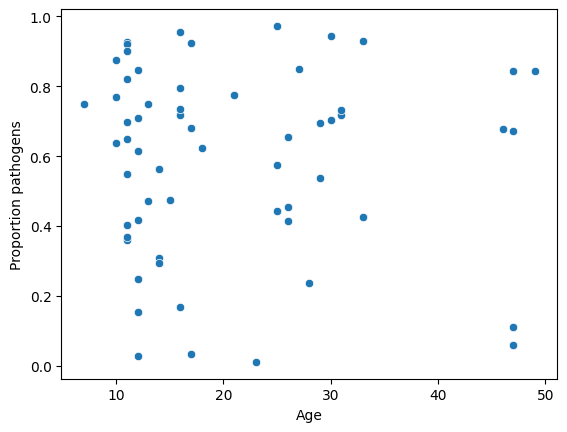

In [8]:
age_pathog = pd.DataFrame()
age_pathog['Proportion pathogens'] = proportions['Proportion Pathogen']
age_pathog = age_pathog.join(metadata[['Age']])

sns.scatterplot(data=age_pathog, x='Age', y='Proportion pathogens')

### Add some statistics

In [9]:
# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = linregress(age_pathog['Age'], age_pathog['Proportion pathogens'])

print(f"The relationship between 'Age' and 'Proportion pathogens' has an equation of y = {slope:.2f}x + {intercept:.2f}, a Pearson r of {r_value:.2f}, and p={p_value:.2f}")

The relationship between 'Age' and 'Proportion pathogens' has an equation of y = -0.00x + 0.60, a Pearson r of -0.02, and p=0.89


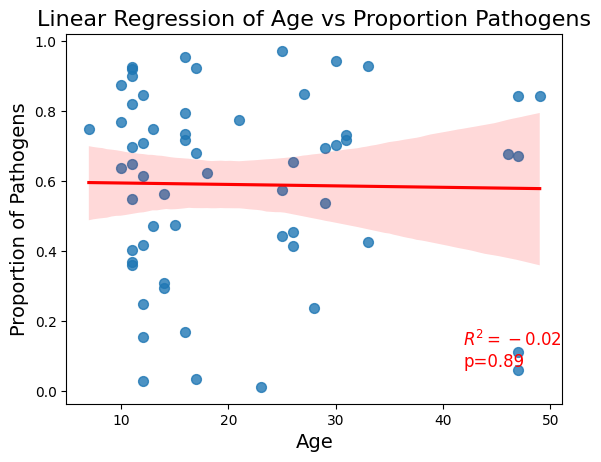

In [10]:
sns.regplot(
    x='Age', y='Proportion pathogens', data=age_pathog, scatter_kws={'s': 50}, line_kws={'color': 'red'}
)

# Annotate the plot with R-squared value
plt.text(
    0.8, 0.1, f"$R^2 = {r_value:.2f}$\np={p_value:.2f}", fontsize=12, transform=plt.gca().transAxes, color='red'
)

# Set labels and title
plt.xlabel('Age', fontsize=14)
plt.ylabel('Proportion of Pathogens', fontsize=14)
plt.title('Linear Regression of Age vs Proportion Pathogens', fontsize=16)
plt.show()


## Proportion pathogens vs. hospital

<Axes: xlabel='Hospital', ylabel='Proportion pathogens'>

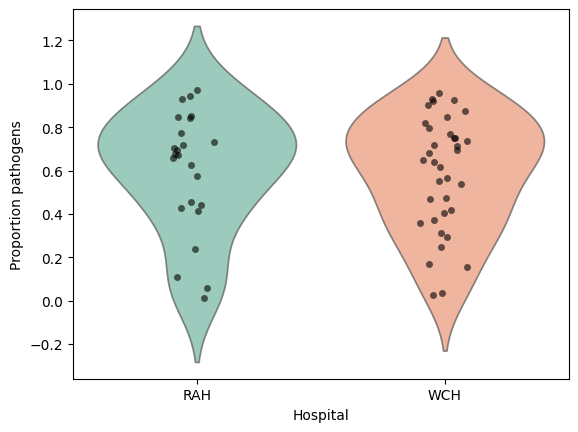

In [11]:
hosp_pathog = pd.DataFrame()
hosp_pathog['Proportion pathogens'] = proportions['Proportion Pathogen']
hosp_pathog = hosp_pathog.join(metadata[['Hospital', 'Paediatric vs Adult']])

sns.violinplot(x='Hospital', y='Proportion pathogens', data=hosp_pathog, inner=None, palette='Set2', alpha=0.7)

# Jittered points
sns.stripplot(x='Hospital', y='Proportion pathogens', data=hosp_pathog, color='black', jitter=True, size=5, alpha=0.6)


<Axes: xlabel='Paediatric vs Adult', ylabel='Proportion pathogens'>

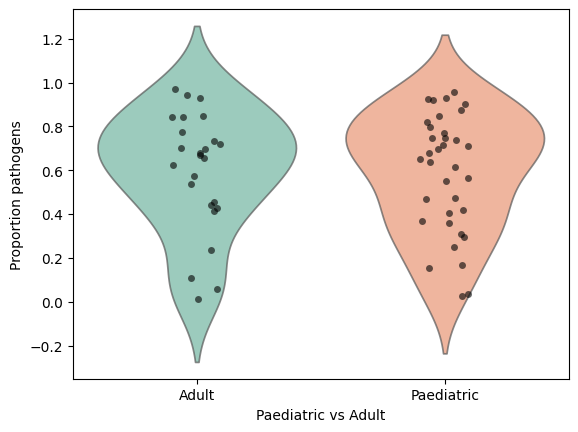

In [12]:
hosp_pathog = pd.DataFrame()
hosp_pathog['Proportion pathogens'] = proportions['Proportion Pathogen']
hosp_pathog = hosp_pathog.join(metadata[['Hospital', 'Paediatric vs Adult']])

sns.violinplot(x='Paediatric vs Adult', y='Proportion pathogens', data=hosp_pathog, inner=None, palette='Set2', alpha=0.7)

# Jittered points
sns.stripplot(x='Paediatric vs Adult', y='Proportion pathogens', data=hosp_pathog, color='black', jitter=True, size=5, alpha=0.6)

## FEV1 vs pathogenicity

Oddly, there does not seem to be a strong relationship between the proportion of pathogens and the FEV1. I would have expected there to be a negative relationship, with more pathogens at a lower FEV1/best FEV or FEV1_RATIO_SCORE.

The relationship between FEV1/best FEV1 and Proportion pathogens has an equation of y = nanx + nan, a Pearson r of nan, and p=nan


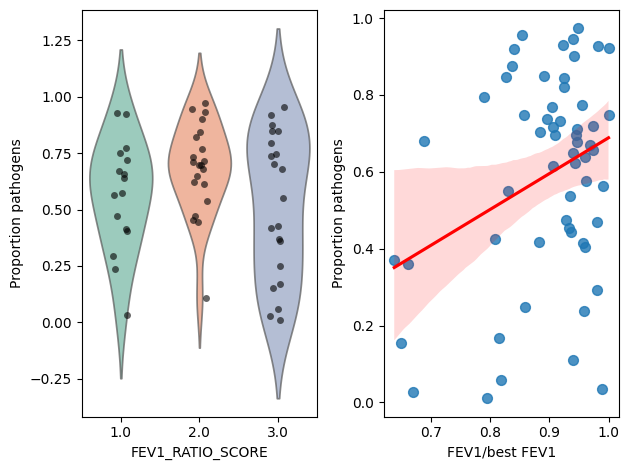

In [13]:
fev_pathog = pd.DataFrame()
fev_pathog['Proportion pathogens'] = proportions['Proportion Pathogen']
fev_pathog = fev_pathog.join(metadata[['FEV1/best FEV1', 'FEV1_RATIO_SCORE']])

ax = plt.subplot(121)

sns.violinplot(x='FEV1_RATIO_SCORE', y='Proportion pathogens', data=fev_pathog, inner=None, palette='Set2', alpha=0.7, ax=ax)

# Jittered points
sns.stripplot(x='FEV1_RATIO_SCORE', y='Proportion pathogens', data=fev_pathog, color='black', jitter=True,  size=5, alpha=0.6, ax=ax)

ax = plt.subplot(122)

x='FEV1/best FEV1'
y='Proportion pathogens'
slope, intercept, r_value, p_value, std_err = linregress(fev_pathog[x], fev_pathog[y])

print(f"The relationship between {x} and {y} has an equation of y = {slope:.2f}x + {intercept:.2f}, a Pearson r of {r_value:.2f}, and p={p_value:.2f}")

sns.regplot(x=x, y=y, data=fev_pathog, scatter_kws={'s': 50}, line_kws={'color': 'red'})
#sns.scatterplot(x=x, y=y, data=fev_pathog, color='black', alpha=0.6, ax=ax)

plt.tight_layout()
plt.show()

In [14]:
pdf = pd.DataFrame(df.loc['Pseudomonas', :].drop('pathogen')).join(metadata[['Hospital', 'Paediatric vs Adult', 'FEV1/best FEV1', 'FEV1_RATIO_SCORE']])
pdf

,Pseudomonas,Hospital,Paediatric vs Adult,FEV1/best FEV1,FEV1_RATIO_SCORE
1068841_20180306_S,485.332953,RAH,Adult,0.969388,1.0
1128691_20171218_S,0.0,RAH,Adult,0.939394,2.0
1128691_20180116_S,308.16641,RAH,Adult,0.818182,3.0
1282052_20180206_S,1597.465006,RAH,Adult,0.923077,2.0
1316935_20180417_S,280.583614,RAH,Adult,0.807692,3.0
1447437_20171006_S,665.983607,RAH,Adult,0.972973,1.0
1447437_20171212_S,146.670578,RAH,Adult,0.918919,2.0
1470026_20180502_S,13.204109,RAH,Adult,0.794872,3.0
1565754_20171128_S,0.0,RAH,Adult,0.961538,1.0
1565754_20180403_S,130.599451,RAH,Adult,0.935897,2.0


In [15]:
df.sum(axis=0)

,0
1068841_20180306_S,540532.438798
1128691_20171218_S,156357.388316
1128691_20180116_S,132511.556240
1282052_20180206_S,600411.150830
1316935_20180417_S,474639.557973
...,...
875028_20180115_S,558689.254971
892355_20180123_S,505967.092719
895293_20180502_S,578248.296107
983493_20180123_S,573541.554479


In [16]:
pdf = pd.DataFrame(df.loc['Pseudomonas', :].drop('pathogen')/df.sum(axis=0).drop('pathogen')).rename(columns={0:'Proportion Pseudomonas'}).join(metadata[['Hospital', 'Paediatric vs Adult', 'FEV1/best FEV1', 'FEV1_RATIO_SCORE']])
pdf['Proportion Pseudomonas'] = pdf['Proportion Pseudomonas'].astype(float)
pdf.head()

,Proportion Pseudomonas,Hospital,Paediatric vs Adult,FEV1/best FEV1,FEV1_RATIO_SCORE
1068841_20180306_S,0.000898,RAH,Adult,0.969388,1.0
1128691_20171218_S,0.000000,RAH,Adult,0.939394,2.0
1128691_20180116_S,0.002326,RAH,Adult,0.818182,3.0
1282052_20180206_S,0.002661,RAH,Adult,0.923077,2.0
1316935_20180417_S,0.000591,RAH,Adult,0.807692,3.0


<Axes: xlabel='Proportion Pseudomonas', ylabel='FEV1/best FEV1'>

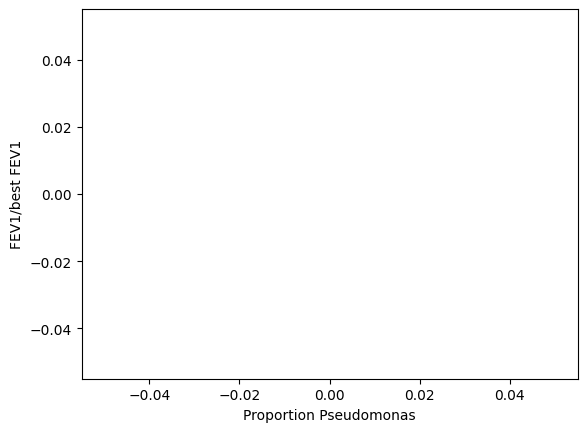

In [17]:
sns.regplot(data=pdf[pdf['Proportion Pseudomonas'] > 0.01], x='Proportion Pseudomonas', y='FEV1/best FEV1', scatter_kws={'s': 50}, line_kws={'color': 'red'})

In [18]:
len(pathogens)



20

In [19]:
pdf.dtypes

,0
Proportion Pseudomonas,float64
Hospital,object
Paediatric vs Adult,object
FEV1/best FEV1,float64
FEV1_RATIO_SCORE,float64


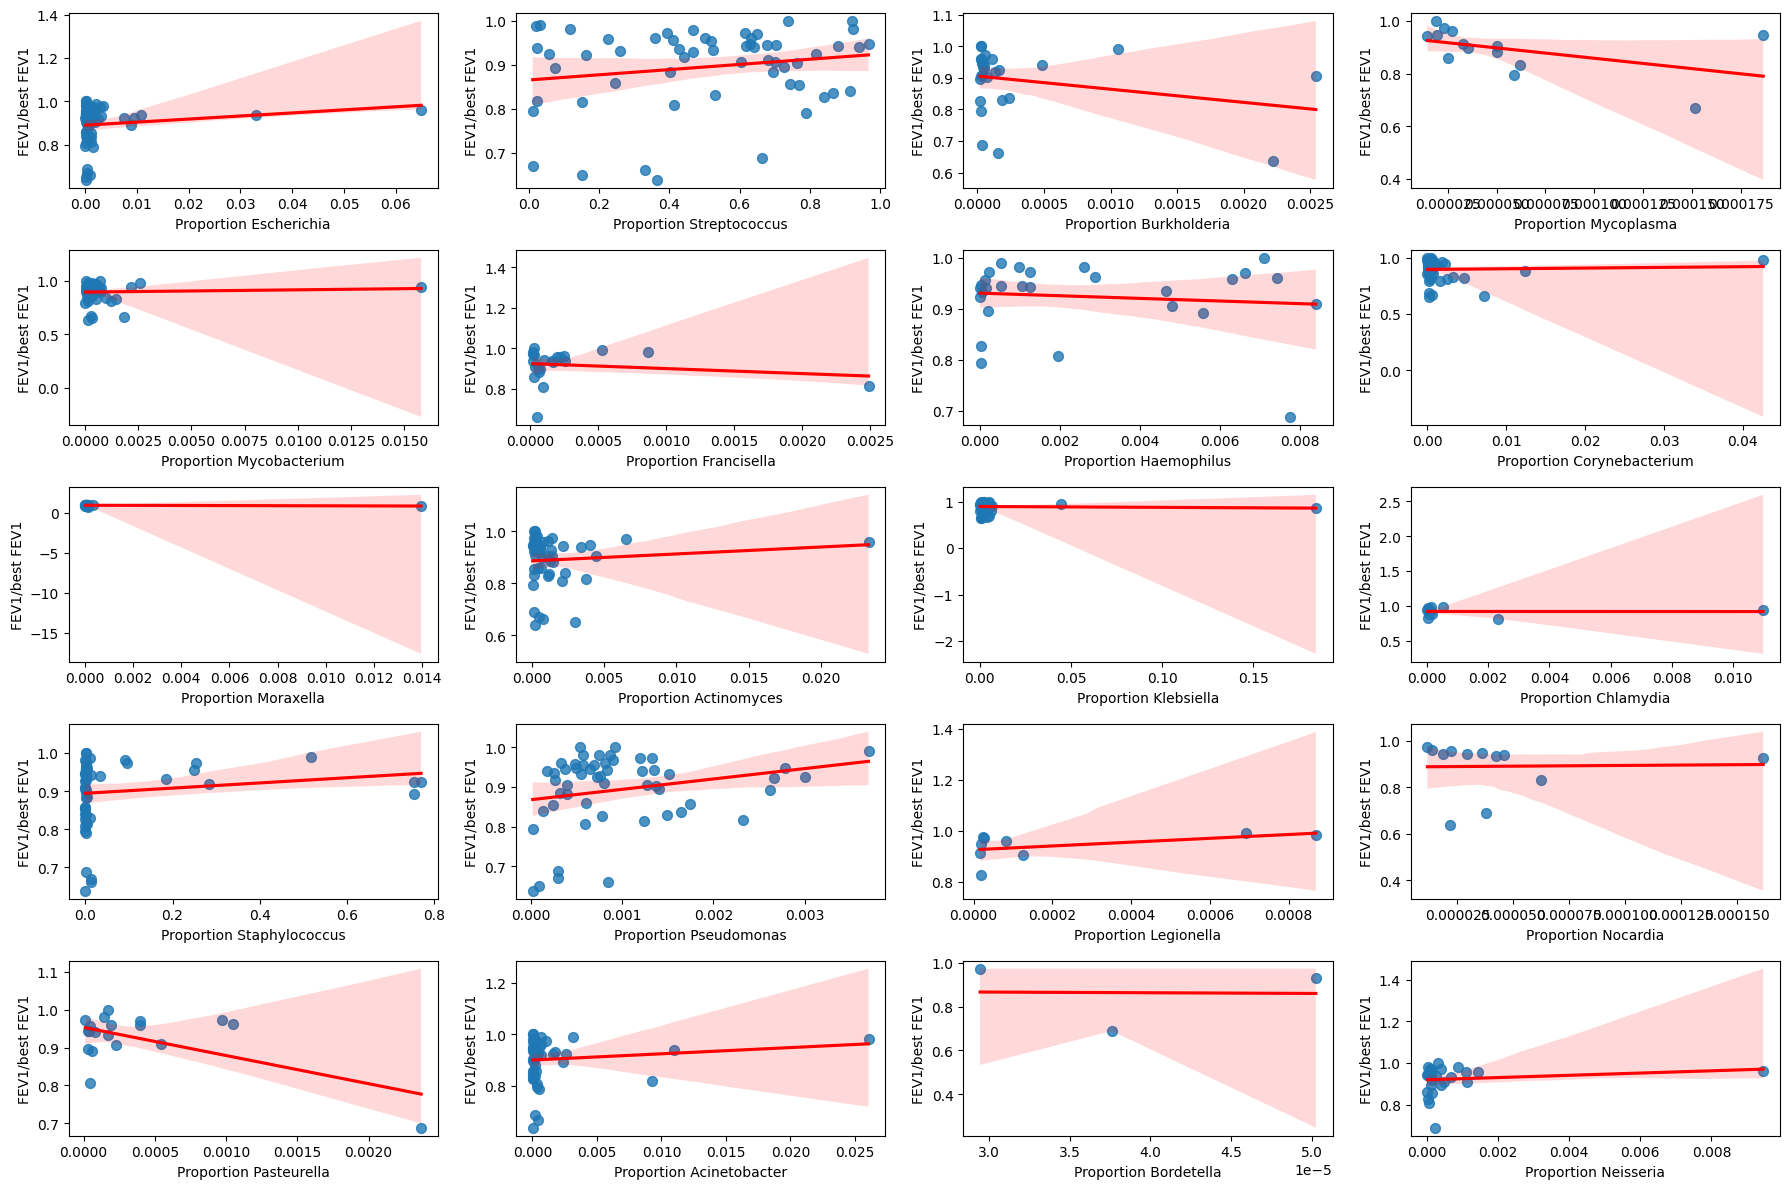

In [20]:
fig, axes = plt.subplots(figsize=(18, 12), nrows=5, ncols=4, sharex=False, sharey=False)

for i, p in enumerate(pathogens):
  ax = axes[i//4, i%4]
  pdf = pd.DataFrame(df.loc[p, :].drop('pathogen')/df.sum(axis=0).drop('pathogen')).rename(columns={0:f'Proportion {p}'}).join(metadata[['FEV1/best FEV1']])
  pdf[f'Proportion {p}'] = pdf[f'Proportion {p}'].astype(float)
  sns.regplot(data=pdf[pdf[f'Proportion {p}'] > 0], x=f'Proportion {p}', y='FEV1/best FEV1', scatter_kws={'s': 50}, line_kws={'color': 'red'}, ax=ax)

plt.tight_layout()
plt.show()